In [1]:
import scanpy as sc
import anndata as ad
from scipy import sparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
import numpy as np
from tqdm import tqdm
from scipy import stats
import colorsys
import json

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


In [2]:
clusters = 100
df = pd.read_csv(f"ms_brain_multisection2_spots_sigma3.0_stride1.0_clusters{clusters}-distance.csv")

Extract class colors from the processed AnnData file:

In [4]:
adata = ad.read_h5ad(rf"adata_multisection_nuclei_3rep_withHM_withclusters.h5ad")

class_color_palette = dict(zip(np.unique(adata.obs['Class']), adata.uns['Class_colors']))
class_color_palette["Background"] = "#000000" 

Extract mean distance to nuclei border for each p2r cluster:

In [ ]:
closer_clust_per_p2r = dict(zip(df["p2r_name"], df["closer_clust"]))

# We compute the mean distance df["distance_nuc_border"] for each p2r_name in df["p2r_name"]:
mean_distance_per_p2r = df.groupby("p2r_name").agg({"distance_nuc_border": "mean"}).reset_index().rename(columns={"distance_nuc_border": "mean_distance_to_nuclei"})
mean_distance_per_p2r = dict(zip(mean_distance_per_p2r["p2r_name"], mean_distance_per_p2r["mean_distance_to_nuclei"]))

We compute the color of each p2r_name in df["p2r_name"] according to the mean distance to the nuclei:
We extract HLS values from the color palette class_color_palette[closer_clust_per_p2r[p2r_name]] for each p2r_name in df["p2r_name"]
and change the H and L value according to the mean distance to the nuclei mean_distance_per_p2r[p2r_name]

In [5]:


def get_color(p2r_name):
    cluster = closer_clust_per_p2r[p2r_name]
    p2r_names_from_cluster = [p for p in closer_clust_per_p2r if closer_clust_per_p2r[p] == cluster]
    if (len(p2r_names_from_cluster) == 1):
        return class_color_palette[cluster]
    # We sort pr2_names_from_cluster according to the mean distance to the nuclei:
    p2r_names_from_cluster = sorted(p2r_names_from_cluster, key=lambda p: mean_distance_per_p2r[p])
    # We get the index of p2r_name in p2r_names_from_cluster:
    index_of_p2r_name = p2r_names_from_cluster.index(p2r_name)

    color = class_color_palette[closer_clust_per_p2r[p2r_name]]
    color = color.lstrip('#')
    color = tuple(int(color[i:i+2], 16) / 255. for i in (0, 2, 4))
    color = colorsys.rgb_to_hls(color[0], color[1], color[2])
    # We normalize the distance between 0.2 and 0.92 according to index_of_p2r_name:
    dist_norm = 0.4 + 0.4 * (index_of_p2r_name / (len(p2r_names_from_cluster)-1))
    hue = color[0] + (0.2 * (index_of_p2r_name / (len(p2r_names_from_cluster)-1)) - 0.1)
    hue = hue % 1

    color = colorsys.hls_to_rgb(hue, dist_norm, color[2])
    # We convert it back to hexa:
    color = '#%02x%02x%02x' % (int(color[0] * 255), int(color[1] * 255), int(color[2] * 255))
    return color
unique_p2r = closer_clust_per_p2r.keys()
color_palette = {p2r_name: get_color(p2r_name) for p2r_name in unique_p2r}

We plot the color palette with the mean distance to the nuclei border for each p2r cluster:

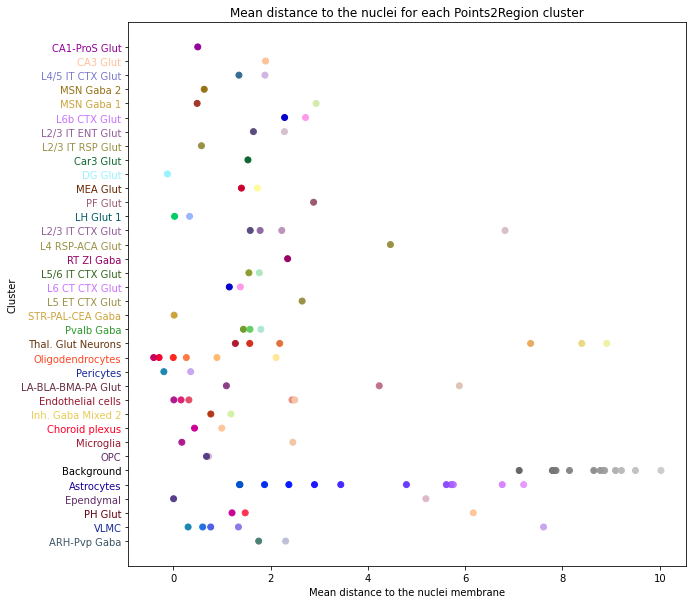

In [7]:
# Plot the color of each p2r_name, with the corresponding mean distance to the nuclei and the corresponding cluster:
fig, ax = plt.subplots(figsize=(10, 10))
keys = closer_clust_per_p2r.keys()
colors = [color_palette[key] for key in keys]
distance = [mean_distance_per_p2r[key] for key in keys]
cluster = [closer_clust_per_p2r[key] for key in keys]
ax.scatter(distance, cluster, c=colors)
ax.set_xlabel("Mean distance to the nuclei membrane")
ax.set_ylabel("Cluster")
ax.set_title("Mean distance to the nuclei for each Points2Region cluster")
# add a color for each y-axis label, according to the cluster:
for i, txt in enumerate(ax.get_yticklabels()):
    txt.set_color(class_color_palette[txt.get_text()])
plt.show()

#save as pdf
fig.savefig("figures/mean_distance_to_nuclei_for_each_cluster.pdf", dpi=300, bbox_inches='tight')

We print the color palette dictionary:

In [ ]:
print (json.dumps(color_palette))

We save the resulting dataframe containing the color column:

In [ ]:
df["color"] = df["p2r_name"].apply(lambda p2r_name: color_palette[p2r_name])
df.to_csv("ms_brain_multisection2_spots_sigma3.0_stride1.0_clusters100-distance.csv", index=False)